# Testing against other software libraries

You should test your results against a similar code using Scikit-Learn (see the examples in the above lecture notes from weeks 41 and 42) or tensorflow/keras or Pytorch (for Pytorch, see Raschka et al.’s text chapters 12 and 13).

Furthermore, you should also test that your derivatives are correctly calculated using automatic differentiation, using for example the Autograd library or the JAX library. It is optional to implement these libraries for the present project. In this project they serve as useful tests of our derivatives.

In [1]:
# import
import autograd.numpy as np
from autograd import grad
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd


# custom imports
from runge_preprocessing import x_train_scaled, y_train, x_test_scaled, y_test, RUNGE_HIDDEN_LAYERS, RUNGE_MAX_ITERATIONS, ETA_VALUES, LAMBDA_VALUES, VERBOSE
from neural_network import create_layers, create_layers_batch, backpropagation, backpropagation_batch, feed_forward, feed_forward_batch
from cost_functions import mse, mse_derivative
from activation_functions import sigmoid, sigmoid_derivative, RELU, RELU_derivative, linear, linear_derivative



In [2]:

# Define function to test different hyperparameters by using SKLEARN - MLPRegressor

def mlp_regressor(x_train_scaled, x_test_scaled, y_test, etas, lambdas, hidden_layers, activation_type, solver_type, max_iterations, verbose=False):
    """
    Docstring created with Copilot
    Code optimized with Copilot (changing appending to list and creating dataframe, and changing verbose)

    Trains and evaluates a neural network model (MLPRegressor) across combinations of learning rates and regularization strengths.

    Parameters:
    ----------
    x_train_scaled : ndarray
        Scaled training input features.
    
    x_test_scaled : ndarray
        Scaled test input features.
    
    y_test : ndarray
        True target values for the test set.
    
    etas : list of float
        List of learning rates to evaluate.
    
    lambdas : list of float
        List of regularization strengths (lambda values) to evaluate.
    
    hidden_layers : tuple
        Structure of hidden layers, e.g., (100,) or (64, 32).
    
    activation_type : str
        Activation function to use in the hidden layers (e.g., 'relu', 'tanh', 'logistic').
    
    solver_type : str
        Optimization algorithm to use (e.g., 'adam', 'sgd', 'lbfgs').
    
    max_iterations : int
        Maximum number of iterations for training.
    
    verbose : bool, optional
        If True, prints detailed training and evaluation information for each parameter combination.

    Returns:
    -------
    Returns a DataFrame with hyperparameters and performance metrics.
    """

    results = []

    for i, eta in enumerate(etas):
        for j, lmbd in enumerate(lambdas):

            dnn = MLPRegressor(hidden_layer_sizes=hidden_layers, activation=activation_type, solver=solver_type, max_iter=max_iterations)
            dnn.fit(x_train_scaled, y_train.ravel())
            
            y_predicted = dnn.predict(x_test_scaled)

            score = dnn.score(y_test, y_predicted)
            r2 = r2_score(y_test, y_predicted)
            mse = mean_squared_error(y_test, y_predicted)

            results.append({
                'Learning Rate': eta,
                'Lambda': lmbd,
                'Score': score,
                'R2': r2,
                'MSE': mse,
                'y_predict': y_predicted
            })


            if verbose:
                print(f"Solver: {solver_type}, eta={eta}, lambda={lmbd}")
                print(f"Score: {score:.4f}, R2: {r2:.4f}, MSE: {mse:.4f}\n")

    return pd.DataFrame(results)


In [3]:
# Test SGD with RMSprop, ADAM and plain GD
## Further implementation needed....



relu_lbfgs = mlp_regressor(x_train_scaled, x_test_scaled, y_test, ETA_VALUES, LAMBDA_VALUES, hidden_layers=RUNGE_HIDDEN_LAYERS, activation_type='relu', solver_type='lbfgs', max_iterations=RUNGE_MAX_ITERATIONS, verbose=VERBOSE)
relu_sgd = mlp_regressor(x_train_scaled, x_test_scaled, y_test, ETA_VALUES, LAMBDA_VALUES, hidden_layers=RUNGE_HIDDEN_LAYERS, activation_type='relu', solver_type='sgd', max_iterations=RUNGE_MAX_ITERATIONS, verbose=VERBOSE)
relu_adam = mlp_regressor(x_train_scaled, x_test_scaled, y_test, ETA_VALUES, LAMBDA_VALUES, hidden_layers=RUNGE_HIDDEN_LAYERS, activation_type='relu', solver_type='adam', max_iterations=RUNGE_MAX_ITERATIONS, verbose=VERBOSE)


c:\Users\brumor\python_env\4155\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 10 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\brumor\python_env\4155\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 10 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Use

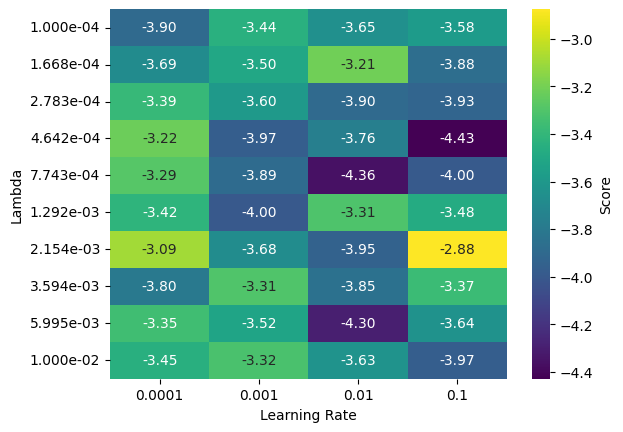

<Figure size 1200x600 with 0 Axes>

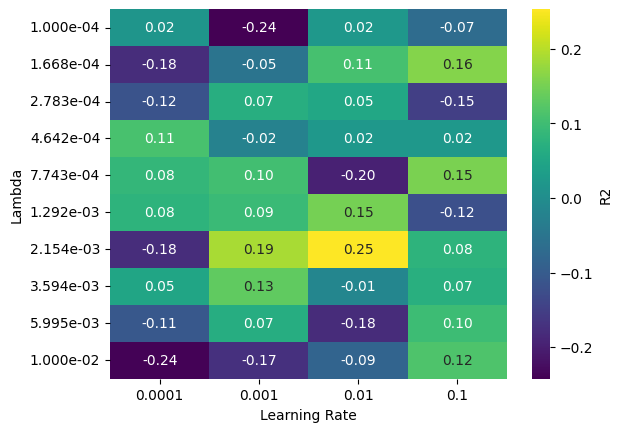

<Figure size 1200x600 with 0 Axes>

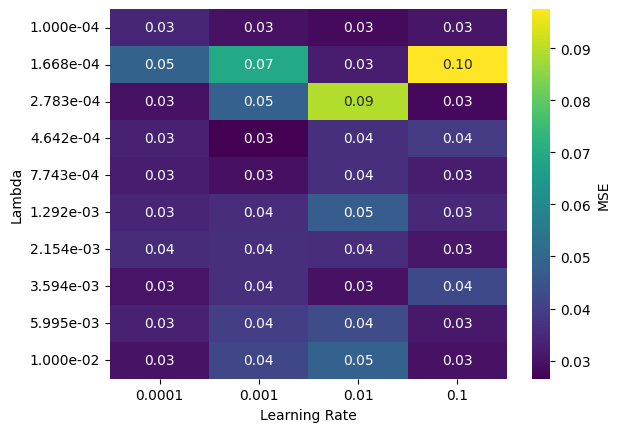

<Figure size 1200x600 with 0 Axes>

In [4]:
# Plot heatmaps

from plotting import plot_heatmap

plot_heatmap(relu_lbfgs, 'Score')
plot_heatmap(relu_sgd, 'R2')
plot_heatmap(relu_adam, 'MSE')



# Option - check if derivatives are correctly calculated using automatic differentiation

In [5]:
# Settings for this task
activation_functions = [sigmoid, sigmoid, linear]
activation_functions_derivatives = [sigmoid_derivative, sigmoid_derivative, linear_derivative]  
network_input_size = 1   # ----> should be the same as number of features, i.e. 1
layer_output_sizes = [RUNGE_HIDDEN_LAYERS[0], RUNGE_HIDDEN_LAYERS[1], 1]   # ---> should be hidden layers and output layer size



# Functions for specifically this task
def cost(layers, input, activation_funcs, target):

    """
    Computes the cost (error) between the predicted output of a feedforward neural network
    and the target output.

    Parameters:
    ----------
    layers : list of tuples
        A list of (W, b) tuples representing the weights and biases for each layer.
    
    input : np.ndarray
        The input vector to the network, typically of shape (input_size,).
    
    activation_funcs : list of callable
        A list of activation functions to apply after each layer's linear transformation.
    
    target : np.ndarray
        The expected output vector (ground truth) for the given input.

    Returns:
    -------
    float
        The cost value, typically computed as the mean squared error (MSE) between
        the predicted output and the target.
    """


    _, _, predict = feed_forward_batch(input, layers, activation_funcs)
    return mse(predict, target)



def compare_gradients(manual_grads, autograd_grads, atol=1e-6):
    """
    Docstring created with Copilot

    Compares manually computed gradients with gradients computed using automatic differentiation.

    Parameters:
    ----------
    manual_grads : list of tuples
        A list where each element is a tuple (dW_manual, db_manual) representing the manually computed 
        gradients of weights and biases for each layer.
    
    autograd_grads : list of tuples
        A list where each element is a tuple (dW_auto, db_auto) representing the gradients computed 
        using automatic differentiation for each layer.
    
    atol : float, optional
        Absolute tolerance parameter for `np.allclose` used to compare the gradients. Default is 1e-6.

    Prints:
    ------
    For each layer, prints whether the weight gradients (`dW`) and bias gradients (`db`) match 
    within the specified tolerance.
    """

    print('Compare gradients between own and autograd calculations:')
    for i, ((dW_manual, db_manual), (dW_auto, db_auto)) in enumerate(zip(manual_grads, autograd_grads)):
        w_close = np.allclose(dW_manual, dW_auto, atol=atol)
        b_close = np.allclose(db_manual, db_auto, atol=atol)
        print(f"Layer {i}: dW match: {w_close}, db match: {b_close}")



def show_gradient_differences(manual_grads, autograd_grads):
    """
    Shows manually computed gradients with gradients computed using automatic differentiation.

    Parameters:
    ----------
    manual_grads : list of tuples
        A list where each element is a tuple (dW_manual, db_manual) representing the manually computed 
        gradients of weights and biases for each layer.
    
    autograd_grads : list of tuples
        A list where each element is a tuple (dW_auto, db_auto) representing the gradients computed 
        using automatic differentiation for each layer.
    
    Prints:
    ------
    For each layer, prints the difference between the weight gradients (`dW`) and bias gradients (`db`).
    """
    print('Differences between own and autograd gradients')
    for i, ((dW_manual, db_manual), (dW_auto, db_auto)) in enumerate(zip(manual_grads, autograd_grads)):
        print(f"Layer {i} - dW diff:\n{dW_manual - dW_auto}")
        print(f"Layer {i} - db diff:\n{db_manual - db_auto}")



# create layers and own implementation of gradients
own_layers = create_layers_batch(network_input_size, layer_output_sizes)
own_gradients = backpropagation_batch(x_train_scaled, own_layers, activation_functions, y_train, activation_functions_derivatives, cost_der=mse_derivative)

# compute gradients with autograd
cost_grad = grad(cost, 0) # 0 means gradients of first input to function -> layers
autograd_gradients = cost_grad(own_layers, x_train_scaled, activation_functions, y_train)

# Show gradients differences between own and autograd implementation
show_gradient_differences(own_gradients, autograd_gradients)

# Compare gradients from own and autograd implementation
compare_gradients(own_gradients, autograd_gradients)





Differences between own and autograd gradients
Layer 0 - dW diff:
[[ 2.22044605e-16  0.00000000e+00  0.00000000e+00 -2.22044605e-16
   0.00000000e+00  0.00000000e+00 -2.22044605e-16  0.00000000e+00
   8.88178420e-16  3.33066907e-16 -5.55111512e-17  0.00000000e+00
  -5.55111512e-17 -2.77555756e-17 -2.22044605e-16  4.44089210e-16
  -1.11022302e-16  2.22044605e-16  0.00000000e+00  0.00000000e+00
   4.44089210e-16 -4.44089210e-16 -6.66133815e-16 -8.32667268e-17
  -1.11022302e-16  2.08166817e-17 -1.66533454e-16 -5.55111512e-17
  -4.44089210e-16 -2.22044605e-16  2.22044605e-16  1.11022302e-16
  -1.11022302e-16 -1.11022302e-16  5.55111512e-17  5.55111512e-17
   2.22044605e-16  3.33066907e-16  2.22044605e-16  1.11022302e-16
  -4.44089210e-16  1.11022302e-16 -1.11022302e-16 -5.55111512e-17
  -4.44089210e-16 -1.11022302e-16  0.00000000e+00  0.00000000e+00
   0.00000000e+00  6.66133815e-16]]
Layer 0 - db diff:
[ 4.44089210e-16 -2.22044605e-16  0.00000000e+00 -2.22044605e-16
  4.44089210e-16 -2.22